In [193]:
import torch
import torch.nn as nn
import gym
# from torchvision.transforms import Grayscale
from parameters import dotdict, MemoryBufferSimple, MemoryBufferSeparated, SensorModel, DriveDQN, model_params, PDriveDQN
from agent_torch_pact import DQN_Agent
from parameters.setup import setup_dict_trans
import environment as env_wrapper
from collections import deque
import matplotlib.pyplot as plt    
import cv2
import random
import numpy as np
from importlib.metadata import version
USE_V2 = '0.21.0' < version('gym') 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
args = model_params
args.device = 'cpu'

In [3]:
def compute_steering_speed_gyro_abs(a):
    right_steering = a[6, 36:46].mean()/255
    left_steering = a[6, 26:36].mean()/255
    steering = (right_steering - left_steering + 1.0)/2
    
    left_gyro = a[6, 46:60].mean()/255
    right_gyro = a[6, 60:76].mean()/255
    gyro = (right_gyro - left_gyro + 1.0)/2
    
    speed = a[:, 0][:-2].mean()/255
    abs1 = a[:, 6][:-2].mean()/255
    abs2 = a[:, 8][:-2].mean()/255
    abs3 = a[:, 10][:-2].mean()/255
    abs4 = a[:, 12][:-2].mean()/255
    
    return [steering, speed, gyro, abs1, abs2, abs3, abs4]

def transform(s):
#     cv2.imshow('original', s)
#     cv2.waitKey(1)

    # crop_img = img[200:400, 100:300] # Crop from x, y, w, h -> 100, 200, 300, 400
    # NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
    # bottom_black_bar is the section of the screen with steering, speed, abs and gyro information.
    # we crop off the digits on the right as they are illigible, even for ml.
    # since color is irrelavent, we grayscale it.
    bottom_black_bar = s[84:, 12:]
    img = cv2.cvtColor(bottom_black_bar, cv2.COLOR_RGB2GRAY)
    bottom_black_bar_bw = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1]
    bottom_black_bar_bw = cv2.resize(bottom_black_bar_bw, (84, 12), interpolation = cv2.INTER_NEAREST)
    
    # upper_field = observation[:84, :96] # this is the section of the screen that contains the track.
    upper_field = s[:84, 6:90] # we crop side of screen as they carry little information
    img = cv2.cvtColor(upper_field, cv2.COLOR_RGB2GRAY)
    upper_field_bw = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)[1]
    upper_field_bw = cv2.resize(upper_field_bw, (10, 10), interpolation = cv2.INTER_NEAREST) # re scaled to 7x7 pixels
#     cv2.imshow('video', upper_field_bw)
#     cv2.waitKey(1)
    upper_field_bw = upper_field_bw.astype('float')/255
        
    car_field = s[66:78, 43:53]
    img = cv2.cvtColor(car_field, cv2.COLOR_RGB2GRAY)
    car_field_bw = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)[1]

#     print(car_field_bw[:, 3].mean()/255, car_field_bw[:, 4].mean()/255, car_field_bw[:, 5].mean()/255, car_field_bw[:, 6].mean()/255)
    car_field_t = [car_field_bw[:, 3].mean()/255, car_field_bw[:, 4].mean()/255, car_field_bw[:, 5].mean()/255, car_field_bw[:, 6].mean()/255]
    
#     rotated_image = rotateImage(car_field_bw, 45)
#     cv2.imshow('video rotated', rotated_image)
#     cv2.waitKey(1)

    return bottom_black_bar_bw, upper_field_bw, car_field_t

In [4]:
if USE_V2:
    env = gym.make('CarRacing-v2', new_step_api=True)
else: 
    env = gym.make('CarRacing-v0')
state_img = env.reset()

In [163]:
# buffer = MemoryBufferSimple(args.n_frames, args.buffer_sz)
buffer = MemoryBufferSeparated(args.n_frames, 400)
sampler = torch.utils.data.DataLoader(buffer, batch_size=32, shuffle=True, drop_last=False)

In [164]:
state = {'img': state_img,
             'steering': 0,
             'speed': 0,
             'gyro': 0,
             'abs1': 0,
             'abs2': 0,
             'abs3': 0,
             'abs4': 0,
             'action_idx': 0}
buffer.add_experience(state, 0, 0, False, new_episode=True) # too add new episode
state_frame_stack = deque(maxlen=args.n_frames)

for i in range(100):
    if USE_V2:
        state_img, reward, terminated, truncated, info = env.step((0.1,1,0))
        done = terminated or truncated 
    else:
        state_img, reward, done, info = env.step((0.1,1,0))
    state_img = state_img/255.0 
    data_board = state_img[84:, 12:]
    steering, speed, gyro, abs1, abs2, abs3, abs4 = compute_steering_speed_gyro_abs(data_board)
    action_idx = random.randint(0, args.act_dim-1)
    state = {'img': state_img,
             'steering': steering,
             'speed': speed,
             'gyro': gyro,
             'abs1': abs1,
             'abs2': abs2,
             'abs3': abs3,
             'abs4': abs4,
             'action_idx': action_idx}
    state_frame_stack.append(state)
    buffer.add_experience(state, action_idx, reward, done)

state_img.shape, reward, done, info

((96, 96, 3), -0.10000000000000009, False, {})

In [7]:
buffer.ep_lengths

deque([101])

In [185]:
sensor_net = SensorModel(args.in_channels, args.h_size,
                         p=args.c_dropout, image_shape=args.img_shape)
states, actions, rewards, dones = next(iter(sampler))

In [186]:
print(list(map(lambda x:x.shape, states)))

[torch.Size([32, 15, 3, 96, 96]), torch.Size([32, 15, 1]), torch.Size([32, 15, 1]), torch.Size([32, 15, 1]), torch.Size([32, 15, 1]), torch.Size([32, 15, 1]), torch.Size([32, 15, 1]), torch.Size([32, 15, 1]), torch.Size([32, 15])]


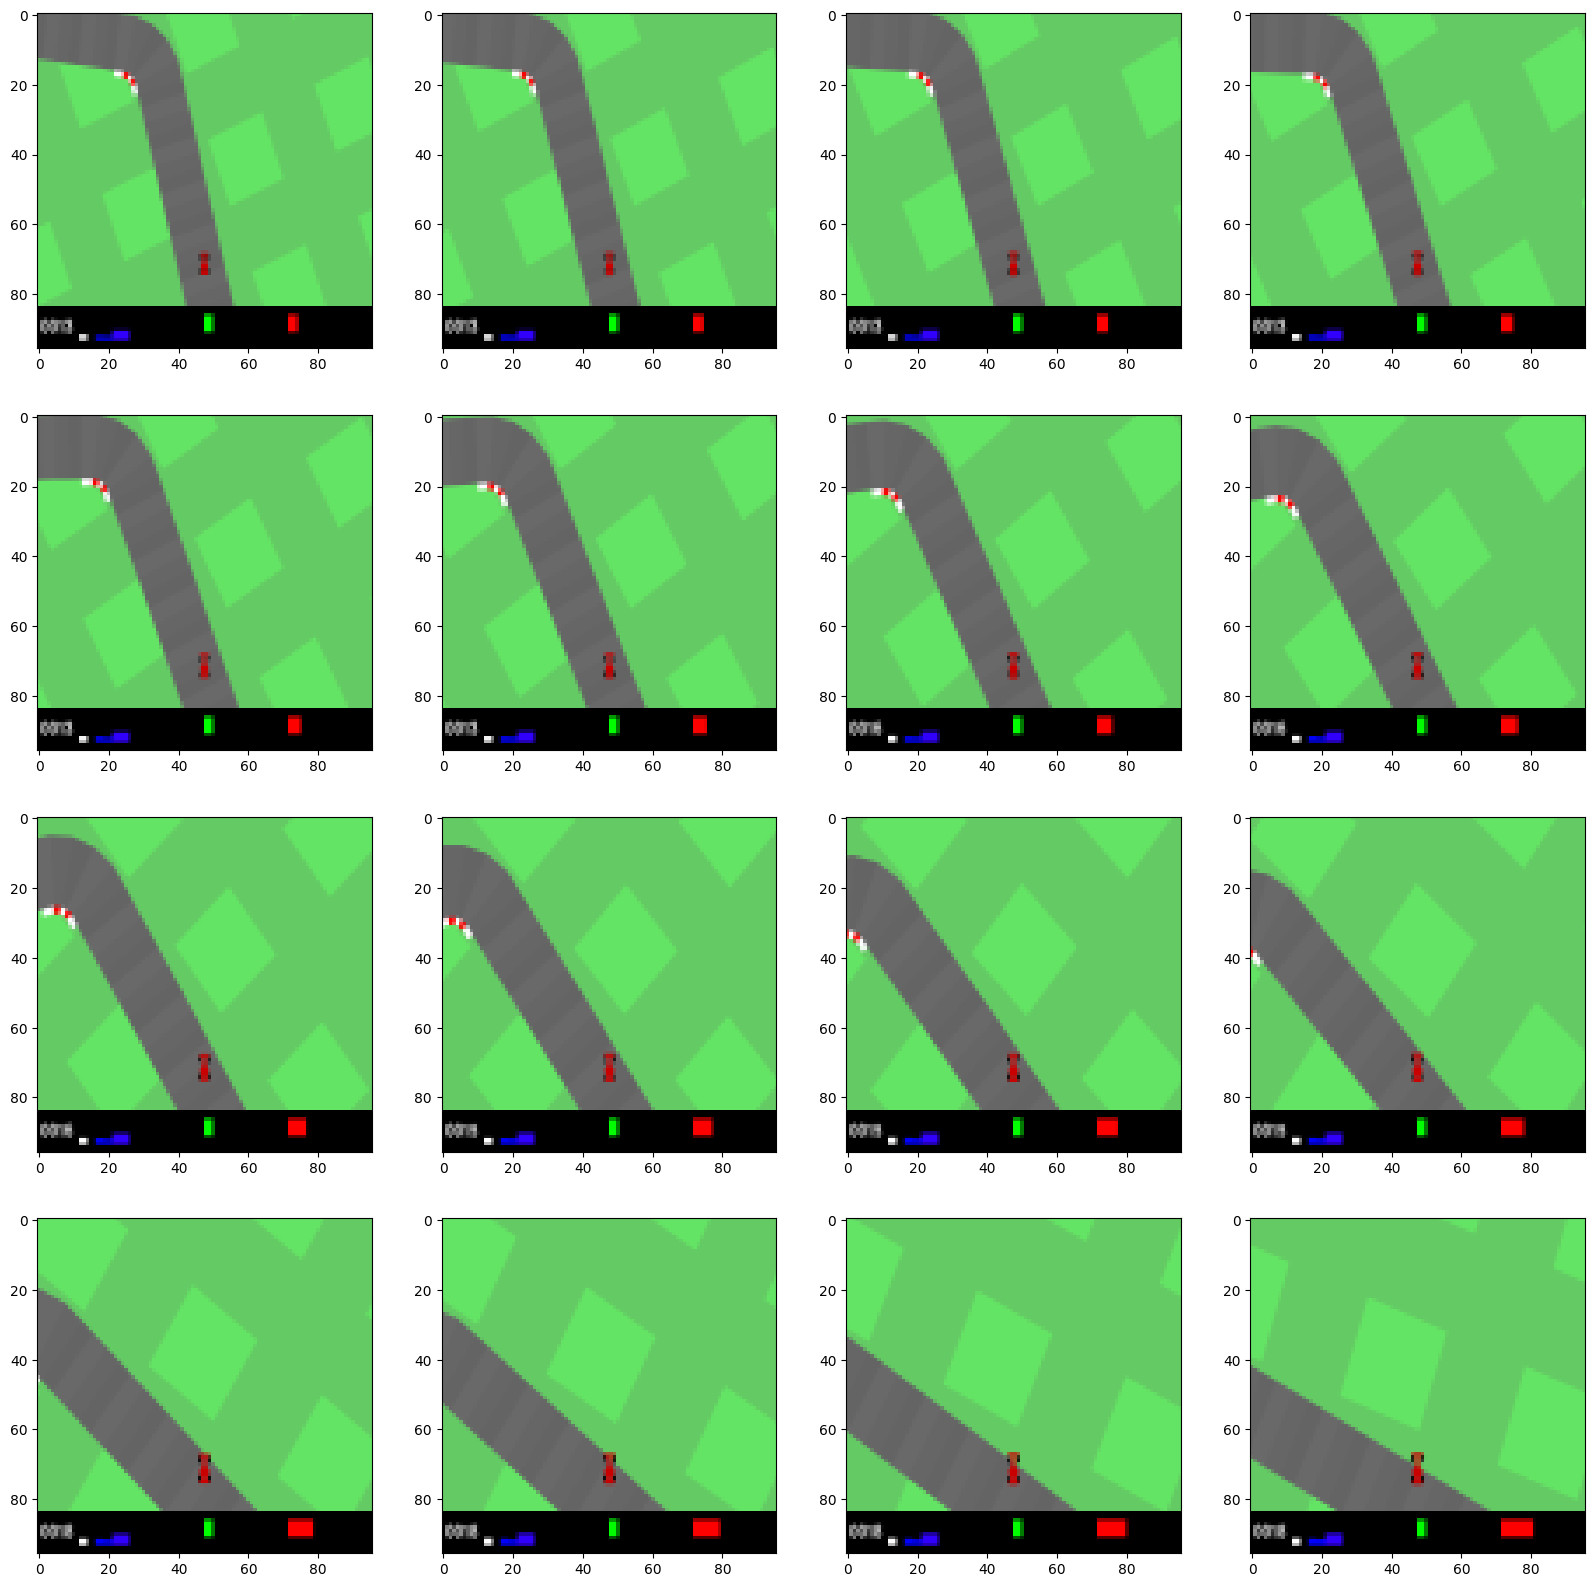

In [10]:
nrows, ncols = 4,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))
batch_idx = 10
for i in range(args.n_frames):
    r = i // nrows
    c = i % ncols
    axs[r][c].imshow(states[0][batch_idx,i,:,:].squeeze(0).permute(1,2,0))

In [132]:
frame_idx = 0 
X_img = states[0].transpose(0,1).to(args.device)
X_sensor = torch.stack(states[1:-1], axis=0).permute(0,2,1,3).to(args.device)
X_act = states[-1].transpose(0,1).to(args.device)
actions = actions.unsqueeze(-1).to(args.device)
rewards = rewards.unsqueeze(1).to(args.device)
dones = dones.unsqueeze(1).to(args.device)
X_img.shape, X_sensor.shape, X_act.shape, actions.shape, rewards.shape, dones.shape, X_img[frame_idx].shape, X_sensor[:,frame_idx].shape

(torch.Size([17, 32, 3, 96, 96]),
 torch.Size([7, 17, 32, 1]),
 torch.Size([17, 32]),
 torch.Size([32, 1]),
 torch.Size([32, 1]),
 torch.Size([32, 1]),
 torch.Size([32, 3, 96, 96]),
 torch.Size([7, 32, 1]))

In [12]:
sensor_hs = sensor_net(X_img[frame_idx], X_sensor[:,frame_idx])
X_img_h, X_steering_h, X_speed_h, X_gyro_h, X_abs1_h, X_abs2_h, X_abs3_h, X_abs4_h = sensor_net(X_img[frame_idx], X_sensor[:,frame_idx])

In [13]:
X_img_h.shape, X_steering_h.shape, X_speed_h.shape, X_gyro_h.shape, X_abs1_h.shape, X_abs2_h.shape, X_abs3_h.shape, X_abs4_h.shape

(torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]))

In [14]:
torch.stack(sensor_hs, axis=0).shape

torch.Size([8, 32, 128])

# Testing Agent Setup

In [194]:
setup_dict_trans['agent']['use_all_timesteps'] = True
setup_dict_trans['agent']['architecture'] = PDriveDQN
environment = env_wrapper.CarRacing(**setup_dict_trans['car racing'])
control = DQN_Agent(environment=environment, **setup_dict_trans['agent'])

In [241]:
control.get_action(state_frame_stack, 0)

1

In [242]:
control.replay_memory = buffer
control.replay_memory_sampler = torch.utils.data.DataLoader(control.replay_memory, batch_size=32, shuffle=True)
buffer_ = control.replay_memory 

In [243]:
control.pact_model.model.pos_embd_local

Embedding(15, 256)

In [244]:
control.dqn(torch.rand(14,32,256)).shape

torch.Size([14, 32, 5])

In [245]:
control.experience_replay_all_steps()

0.02200389839708805

In [23]:
sum((p.numel() for p in control.dqn.sensor_net.cnn.parameters()))

4860704

In [19]:
X_img = states[0].transpose(0,1).to(args.device)
X_sensor = torch.stack(states[1:-1], axis=0).transpose(1,2).unsqueeze(-1).to(args.device)
X_act = states[-1].transpose(0,1).to(args.device)
cur_state = (X_img[:-1], X_sensor[:,:-1], X_act[:-1])
next_state = (X_img[1:], X_sensor[:, 1:], X_act[1:])
actions = actions.unsqueeze(-1).to(args.device)
rewards = rewards.unsqueeze(1).to(args.device)
dones = dones.unsqueeze(1).to(args.device)
X_img.shape, X_sensor.shape, X_act.shape, actions.shape, rewards.shape, dones.shape, cur_state[0].shape, next_state[0].shape

(torch.Size([17, 32, 3, 96, 96]),
 torch.Size([7, 17, 32, 1, 1]),
 torch.Size([17, 32]),
 torch.Size([32, 1, 1, 1]),
 torch.Size([32, 1, 1, 1]),
 torch.Size([32, 1, 1, 1]),
 torch.Size([16, 32, 3, 96, 96]),
 torch.Size([16, 32, 3, 96, 96]))

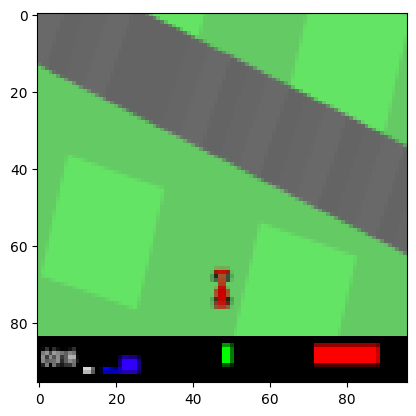

In [20]:
plt.imshow(X_img[0,0].permute(1,2,0).numpy())

In [21]:
def _generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Causal

In [22]:
t = args.n_frames = 14
X_states = torch.rand(t,32, args.h_size)
actions_idx = torch.arange(4).repeat(t,32//4) # discrete actions 
actions_emb = nn.Embedding(5, args.h_size)
actions_d_h = actions_emb(actions_idx)
actions_r_steer = torch.rand(t,32,1) # real valued action measures mlp scaled
actions_r_throttle = torch.rand(t,32,1)
actions_r_brake = torch.rand(t,32,1)
action_tokenizer = nn.Sequential(nn.Linear(1, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, args.h_size))
merge_actions = nn.Sequential(nn.Conv1d(in_channels=3, out_channels=9, kernel_size=9, padding='same'),
                              nn.ReLU(),
                              nn.Conv1d(in_channels=9, out_channels=1, kernel_size=9, padding='same'))

In [23]:
actions_h_steer = action_tokenizer(actions_r_steer)
actions_h_throttle = action_tokenizer(actions_r_throttle)
actions_h_brake = action_tokenizer(actions_r_brake)
actions_r_h = torch.stack([actions_h_steer, actions_h_throttle, actions_h_brake], dim=2)
actions_r_h = merge_actions(actions_r_h.view(-1,3,128)).view(t,32,128)
actions_h = actions_r_h + actions_d_h
X_states.shape, actions_h.shape

(torch.Size([14, 32, 128]), torch.Size([14, 32, 128]))

In [53]:
t = args.n_frames
pos_embd_local = nn.Embedding(t, args.h_size)
pos_embd_global = nn.Embedding(2*t, args.h_size)

In [55]:
pos_local = torch.arange(t, dtype=torch.long, device=args.device).unsqueeze(-1)
pos_global = torch.arange(2*t, dtype=torch.long, device=args.device).unsqueeze(-1)

In [56]:
pos_local_h = pos_embd_local(pos_local).repeat_interleave(2, dim=0)
pos_global_h = pos_embd_global(pos_global)
pos_local_h.shape, pos_global_h.shape

(torch.Size([28, 1, 128]), torch.Size([28, 1, 128]))

In [57]:
state_act_seq = torch.stack([X_states, actions_h], dim=1).reshape(-1, 32, args.h_size)
assert (state_act_seq[::2,:,:] == X_states).all() and (state_act_seq[1::2,:,:] == actions_h).all()
state_act_seq = state_act_seq + pos_local_h + pos_global_h

In [58]:
d_size = args.h_size
encoder_layer = nn.TransformerEncoderLayer(d_model=d_size, nhead=args.n_head, 
                                           dim_feedforward=4*d_size, dropout=args.t_dropout, norm_first=args.norm_first)
gpt = nn.TransformerEncoder(encoder_layer, num_layers=args.n_decs)
mask = _generate_square_subsequent_mask(None,t*2).to(args.device)
state_head = nn.Sequential(nn.Linear(2*args.h_size, args.h_size))

In [59]:
state_act_seq_h = gpt(state_act_seq, mask=mask)
state_act_seq_h = state_act_seq_h.transpose(0,1) # S,B,... -> B,S,...
state_act_seq_h.shape

torch.Size([32, 28, 128])

In [60]:
state_act_seq_h1 = state_act_seq_h.reshape(32,t,-1).transpose(0,1) # B,S,... -> S,B,...
state_act_seq_h1.shape

torch.Size([14, 32, 256])

In [61]:
state_preds = state_head(state_act_seq_h1)
state_preds.shape

torch.Size([14, 32, 128])

In [62]:
criterion = nn.MSELoss()

In [63]:
loss = criterion(state_preds, torch.rand(14,32,128))

In [64]:
from parameters.pact import PACTBase, PACTStateTokenizer, PACTActionTokenizer, PACTTokenizer, PACTPretrain

# state tokenizer

In [65]:
args.c_dropout = 0
state_tokenizer = PACTStateTokenizer(args)

In [68]:
X_sensor = X_sensor.squeeze(-1)
X_img.shape, X_sensor.shape

(torch.Size([17, 32, 3, 96, 96]), torch.Size([7, 17, 32, 1]))

In [69]:
state_h = []
imgs_h = []
state_tokenizer.eval()
for i in range(len(X_img)):
    state_h.append(state_tokenizer(X_img[i], X_sensor[:,i]))
    imgs_h.append(state_tokenizer.cnn(X_img[i]))
imgs_h = torch.cat(imgs_h,dim=0)
state_h_sep = torch.stack(state_h)
imgs_h.shape, state_h_sep.shape

(torch.Size([544, 128]), torch.Size([17, 32, 256]))

In [70]:
state_h_full = state_tokenizer(X_img.reshape(-1, args.in_channels, *args.img_shape), 
                               X_sensor.reshape(7,-1,1))
state_h_full.shape

torch.Size([544, 256])

In [71]:
t,b=X_img.shape[:2]

In [72]:
state_h_full.reshape(t,32,-1)[:,:,:128].shape, state_h_sep[:,:,:128].shape

(torch.Size([17, 32, 128]), torch.Size([17, 32, 128]))

In [73]:
torch.allclose(state_h_full.reshape(t,32,-1)[:,:,:128], 
               state_h_sep[:,:,:128], atol=1e-6)

True

In [74]:
torch.allclose(state_h_full.reshape(t,32,-1)[:,:,128:], 
               state_h_sep[:,:,128:], atol=1e-6)

True

# action tokenizer

In [75]:
action_tokenizer = PACTActionTokenizer(args)

In [76]:
actions_r = torch.stack([actions_r_steer, actions_r_throttle, actions_r_brake], dim=0)
actions_idx 
actions_h = action_tokenizer(actions_idx, actions_r)
actions_idx.shape, actions_r.shape

(torch.Size([14, 32]), torch.Size([3, 14, 32, 1]))

# state tokenizer

In [79]:
state_h_full = state_h_full.reshape(t,b,-1)
state_h_full.shape, actions_h.shape

(torch.Size([17, 32, 256]), torch.Size([14, 32, 256]))

In [81]:
state_act_seq = torch.stack([state_h_full[:-3], actions_h], dim=1).reshape(-1, 32, args.h_size*2)

# pact tokenizer

In [86]:
batch = {'state': {'X_img': X_img[:-3],
                    'X_sensor': X_sensor[:,:-3]},
         'action': {'X_act_idx': actions_idx,
                    'X_act': actions_r}
         }
tokenizer = PACTTokenizer(args)
token_embd_dict = tokenizer(batch)
token_embd_dict['state'].shape, token_embd_dict['action'].shape 

(torch.Size([14, 32, 256]), torch.Size([14, 32, 256]))

# pact base

In [87]:
model = PACTBase(args)

In [88]:
print(list(map(lambda x:x.shape, batch['state'].values())))
print(list(map(lambda x:x.shape, batch['action'].values())))

[torch.Size([14, 32, 3, 96, 96]), torch.Size([7, 14, 32, 1])]
[torch.Size([14, 32]), torch.Size([3, 14, 32, 1])]


In [89]:
out_embd, state_targets = model(batch)
out_embd.shape, state_targets.shape

(torch.Size([28, 32, 256]), torch.Size([14, 32, 256]))

In [90]:
pact_model = PACTPretrain(args)

In [91]:
state_preds, state_embd = pact_model(batch)
state_preds.shape, state_embd.shape

(torch.Size([14, 32, 256]), torch.Size([14, 32, 256]))

In [92]:
criterion(state_preds, state_embd)

tensor(0.3368, grad_fn=<MseLossBackward0>)

In [102]:
action_dict = torch.tensor([[-1, 0, 0],
               [1, 0, 0], 
               [0, 1, 0], 
               [0, 0, 0.8],
               [0, 0, 0]], dtype=torch.float32)

In [119]:
X_act[0,4]

tensor(3)

In [120]:
action_dict[X_act][0,4]

tensor([0.0000, 0.0000, 0.8000])

In [145]:
action_dict[X_act].permute(2,0,1).unsqueeze(-1)

torch.Size([3, 17, 32, 1])

In [99]:
action_dict[[0,1,2]]

TypeError: unhashable type: 'list'

In [135]:
actions.shape, X_act.shape

(torch.Size([32, 1]), torch.Size([17, 32]))

In [137]:
X_act[-1].shape

torch.Size([32])

In [143]:
X_act.shape

torch.Size([17, 32])

In [144]:
actions_idx.shape

torch.Size([14, 32])